## Sentiment Analysis of Reviews

Dataset Source: https://www.kaggle.com/datasets/marklvl/sentiment-labelled-sentences-data-set

##### Import Necessary Libraries

In [0]:
import pandas

import pyspark

from pyspark.sql.types import StructType, StructField, IntegerType, StringType
import pyspark.sql.functions as F

import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#### Create Functions Used Throughout Project

##### Create Function to Ingest Data

In [0]:
def ingest_data(file_location: str) -> pandas.DataFrame:
    '''
    This function ingests a single data file at a time.
    '''
    
    file_type = "csv"
    infer_schema = "false"
    first_row_is_header = "false"
    line_sep = '\n'
    
    dataset = spark.read.text(file_location, lineSep="\n")
    
    dataset = dataset.withColumn("text", F.split(dataset['value'], '\t').getItem(0)) \
                    .withColumn("label", F.split(dataset['value'], '\t').getItem(1)) \
                    .drop("value")
    
    return dataset

##### Define Function to Ingest & Concatenate Multiple Files at Once

In [0]:
def ingest_multiple_files(files: [], schema: StructType) -> pandas.DataFrame:
    '''
    This function concatenates multiple data files into one after calling 
    the 'ingest_data' function to ingest them individually.
    '''
    temp_df = spark.createDataFrame([], schema)
    new_df = spark.createDataFrame([], schema)
    
    for x in files:
        # Ingest next dataset
        temp_df = ingest_data(x)
        # Concatenate it to existing dataset
        new_df = new_df.union(temp_df)
        # unpersist the temp_df
        temp_df.unpersist()
    
    return new_df

##### Define Function to Evaluate Metrics

In [0]:
def metrics_eval(prediction: pandas.Series, label: pandas.Series, model_name: str) -> None:
    '''
    This function calculates and displays the following metrics:
    - Classification Report (including accuracy, recall, precision, 
        & F1-score, among others)
    - Confusion Matrix
    '''
    
    print("-------------------------------------------------------------")
    print(f"The {model_name} Model:")
    print("-------------------------------------------------------------")
    print(f"Classification Report for the {model_name} Model:")
    
    report = classification_report(label, prediction, zero_division=1)
    print(report)
    
    print("-------------------------------------------------------------")
    
    print(f"Confusion Matrix for the {model_name} Model:")
    cm = confusion_matrix(label, prediction)
    dist = ConfusionMatrixDisplay(confusion_matrix=cm)
    dist.plot()
    
    print("-------------------------------------------------------------")

#### Ingest & Preprocess Dataset

In [0]:
file_1 = "/FileStore/tables/amazon_cells_labelled.txt"
file_2 = "/FileStore/tables/imdb_labelled.txt"
file_3 = "/FileStore/tables/yelp_labelled.txt"

files_to_ingest = [file_1, file_2, file_3]

orig_schema = StructType([
    StructField("text", StringType(), True),
    StructField("label", StringType(), True),
])

df = ingest_multiple_files(files_to_ingest, orig_schema)

df = df.withColumn("text_len", F.size(F.split(F.col('text'), ' ')))

df = df.withColumn("label",\
        F.when(df["label"]=="0", F.regexp_replace(df["label"], "0", "negative"))\
        .when(df["label"]=="1", F.regexp_replace(df["label"], "1", "positive")))

df = df.na.drop(subset=["label"])

display(df)

text,label,text_len
So there is no way for me to plug it in here in the US unless I go by a converter.,negative,21
"Good case, Excellent value.",positive,4
Great for the jawbone.,positive,4
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!,negative,11
The mic is great.,positive,4
I have to jiggle the plug to get it to line up right to get decent volume.,negative,17
"If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.",negative,21
If you are Razr owner...you must have this!,positive,8
"Needless to say, I wasted my money.",negative,7
What a waste of money and time!.,negative,7


Output can only be rendered in Databricks

Output can only be rendered in Databricks

##### Remove Unnecessary Feature

In [0]:
df = df.drop("text_len")

#### Define Pipeline Stages & Instantiate Pipeline

##### Create Pipeline Stages

In [0]:
MODEL_NAME='sentimentdl_use_twitter'

document_assembler = DocumentAssembler() \
    .setInputCol("text")\
    .setOutputCol("doc")
    
use = UniversalSentenceEncoder.pretrained(name="tfhub_use", lang="en")\
    .setInputCols(["doc"])\
    .setOutputCol("use")

sent_dl_clf = SentimentDLModel.pretrained(MODEL_NAME, lang='en')\
    .setInputCols(["use"])\
    .setOutputCol("class")

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.4 MB
[OK!]


##### Create Pipeline

In [0]:
sent_dl_pipe = Pipeline().setStages([document_assembler, use, sent_dl_clf])

#### Evaluate Samples & Evaluate Results

##### Train & Create Predictions Using Trained Sentiment Analysis Model

In [0]:
preds = sent_dl_pipe.fit(df).transform(df)

##### Return Condensed Predictions in Pandas DataFrame Form

In [0]:
preds_in_pandas = (preds.select(F.col('text').alias("text"), F.col('label').alias("ground_truth"), F.col('class.result').alias("prediction"))).toPandas()

preds_in_pandas['prediction'] = preds_in_pandas['prediction'].apply(lambda x : x[0])

##### Display Metrics via Metrics Function Defined Above

-------------------------------------------------------------
The Sentiment Analysis Model:
-------------------------------------------------------------
Classification Report for the Sentiment Analysis Model:
              precision    recall  f1-score   support

    negative       0.83      0.80      0.81      1500
     neutral       0.00      1.00      0.00         0
    positive       0.83      0.81      0.82      1500

    accuracy                           0.81      3000
   macro avg       0.55      0.87      0.55      3000
weighted avg       0.83      0.81      0.82      3000

-------------------------------------------------------------
Confusion Matrix for the Sentiment Analysis Model:
-------------------------------------------------------------


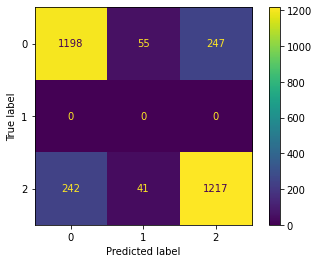

In [0]:
metrics_eval(preds_in_pandas['prediction'], preds_in_pandas['ground_truth'], "Sentiment Analysis")

#### End Spark Session

In [0]:
spark.stop()

### Notes & Other Takeaways From This Project
****
- I am a little surprised that the results were not better. My expectation was that accuracy, recall, precision & f1-score would all reach at least ninety percent (90%).
****
- I happy to announce that functions I have created are type-checked.
****
- Also, each function includes a comment describing what they do.
****